In [27]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [28]:
num_visible = 4
num_hidden = 2 

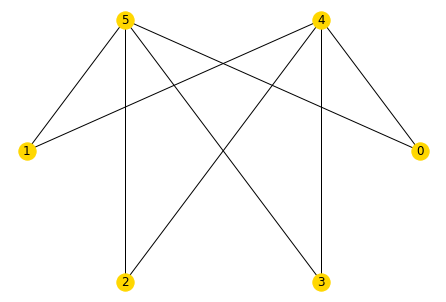

In [29]:
visible = [i for i in range(num_visible)]
hidden = [num_visible + j for j in range(num_hidden)]
edges = [(i, j) for i in visible for j in hidden]

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_circular(G, with_labels=True, node_color='gold')

In [31]:
from active_coresets.QBM import QuantumBoltzmannMachine
from active_coresets.pamc_qbm import PAMC_QBM

In [6]:
base_qbm = QuantumBoltzmannMachine(G, visible, hidden, 2)
data_dist = base_qbm.sample(500)

2022-03-04 11:33:24.330093: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-03-04 11:33:24.330145: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jviszlai-XPS-15-9570): /proc/driver/nvidia/version does not exist
2022-03-04 11:33:24.330637: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor(
[[ 1.  1. -1. ...  1.  1.  1.]
 [ 1.  1. -1. ...  1.  1.  1.]
 [ 1.  1. -1. ... -1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [-1.  1.  1. ...  1. -1.  1.]
 [-1.  1.  1. ...  1. -1.  1.]], shape=(535, 10), dtype=float32)


In [7]:
v_data = data_dist[:,:num_visible]

In [34]:
pamc_qbm = PAMC_QBM(visible, hidden, 2, 512)
pamc_qbm.train(v_data, 1, 10, np.linspace(0, 1, 5).astype(np.float32), 10)

TypeError: in user code:

    File "/home/jviszlai/Documents/Research/Coresets/Bayesian-inference-coresets/active_coresets/qmc_tim_qbm.py", line 169, in anneal  *
        bws = tf.maximum(epsilon,
    File "/home/jviszlai/Documents/Research/Coresets/Bayesian-inference-coresets/active_coresets/qmc_tim_qbm.py", line 82, in beta_energy  *
        classical_energy = tf.multiply(beta, tf.reduce_mean(classical_energy_slices),

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.


In [13]:
sample_dict = {}
for z_pt in v_data:
    pt = tuple(z_pt)
    if pt in sample_dict:
        sample_dict[pt] += 1
    else:
        sample_dict[pt] = 1
sample_dist = {k: v / sum(sample_dict.values()) for k, v in sample_dict.items()}

In [33]:
import importlib
import active_coresets
importlib.reload(active_coresets.QBM)
importlib.reload(active_coresets.qmc_tim_qbm)
importlib.reload(active_coresets.pamc_qbm)
from active_coresets.pamc_qbm import PAMC_QBM
from active_coresets.QBM import QuantumBoltzmannMachine

In [19]:
qbm_exact = QuantumBoltzmannMachine(G, visible, hidden, 2)
qbm_exact.exact_train(v_data, sample_dist, step_size=.5, batch_size=50, epochs=5, beta=1)

Epoch 1/5:
....Batch: 1/10
Finished batch: 0:
	|L_i - L_i+1| = |4.36185+0.00000j - 4.23010+0.00000j| = 0.13175
....Batch: 2/10
Finished batch: 1:
	|L_i - L_i+1| = |4.23010+0.00000j - 4.14855+0.00000j| = 0.08155
....Batch: 3/10
Finished batch: 2:
	|L_i - L_i+1| = |4.14855+0.00000j - 4.11425+0.00000j| = 0.03430
....Batch: 4/10


KeyboardInterrupt: 

/home/jviszlai/Envs/coresets/lib/python3.7/site-packages/matplotlib/transforms.py:788: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


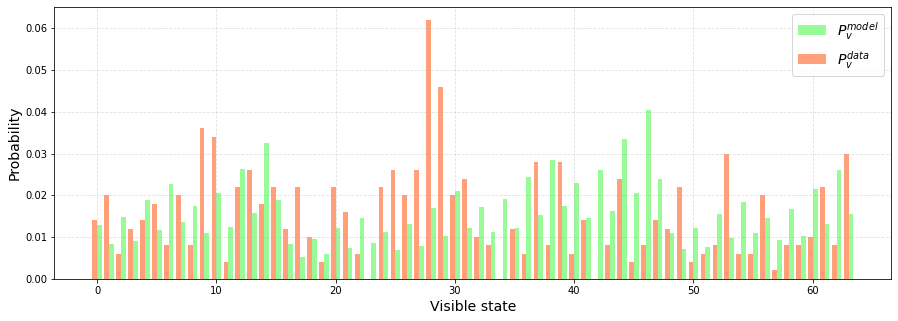

In [14]:
model_dist = qbm_exact.get_distribution(beta=1)
qbm_exact.plot_dist(model_dist, sample_dist)

In [24]:
qbm_classical = QuantumBoltzmannMachine(G, visible, hidden, 2)
qbm_classical.classical_train(v_data, batch_size=50, epochs=5)

Epoch 1/5:
....Batch: 1/10
....Batch: 2/10


In [20]:
qbm_disc = QuantumBoltzmannMachine(G, visible, hidden, 2)
qbm_disc.classical_train_disc(v_data, 1, batch_size=50, epochs=1)

Epoch 1/1:
....Batch: 1/10
....Batch: 2/10
....Batch: 3/10
....Batch: 4/10
....Batch: 5/10
....Batch: 6/10
....Batch: 7/10
....Batch: 8/10
....Batch: 9/10
....Batch: 10/10
Training done!


In [21]:
prediction = qbm_disc.predict(1, v_data[0,:-1])
print(v_data[0])
print(prediction)

[-1. -1. -1. -1. -1. -1.]
[[-1.]]


In [22]:
correct = 0
for data in v_data:
    prediction = qbm_disc.predict(1, data[:-1])
    if prediction == data[-1]:
        correct += 1
        print(f'Correct: {correct}')
    else:
        print(f'Incorrect: Prediction: {prediction}, Data: {data[-1]}')

Incorrect: Prediction: [[1.]], Data: -1.0


KeyboardInterrupt: 